<a href="https://colab.research.google.com/github/MDankloff/ClusterCompasCredit/blob/main/Pre-processing/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import os


# LOAD DATA

In [8]:
originalcompas = pd.read_csv("https://raw.githubusercontent.com/MDankloff/ClusterCompas/main/Data/compas-scores-two-years.csv")

#originalcompas.info()
#originalcompas.head()

In [9]:
#Check if is_recid and two year recid are the same
'''if (originalcompas['is_recid'] == originalcompas['two_year_recid']).any():
    print("same")
else:
    print("not same")'''

'if (originalcompas[\'is_recid\'] == originalcompas[\'two_year_recid\']).any():\n    print("same")\nelse:\n    print("not same")'

In [10]:
compas = originalcompas.drop(['age_cat','event','priors_count.1','is_violent_recid','is_recid','score_text','v_decile_score','id','name','first','last', 'dob', 'compas_screening_date', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
                     'c_charge_degree', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date',
                     'vr_charge_desc', 'screening_date', 'v_screening_date', 'in_custody', 'out_custody', 'start', 'end', 'decile_score.1', 'v_score_text', 'type_of_assessment', 'v_type_of_assessment'], axis=1)
compas.info()
compas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sex             7214 non-null   object
 1   age             7214 non-null   int64 
 2   race            7214 non-null   object
 3   decile_score    7214 non-null   int64 
 4   priors_count    7214 non-null   int64 
 5   two_year_recid  7214 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 338.3+ KB


,sex,age,race,decile_score,priors_count,two_year_recid
0,Male,69,Other,1,0,0
1,Male,34,African-American,3,0,1
2,Male,24,African-American,4,4,1
3,Male,23,African-American,8,1,0
4,Male,43,Other,1,2,0


In [11]:
#get Dummies for sex, age_cat and race
dummy_cols = ['sex', 'race']
compas_2_dummies = pd.get_dummies(compas[dummy_cols], columns = dummy_cols, prefix=dummy_cols)
compas_2 = pd.concat([compas, compas_2_dummies], axis=1)

#print(compas_2.columns)
compas_2.info()
compas_2.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sex                    7214 non-null   object
 1   age                    7214 non-null   int64 
 2   race                   7214 non-null   object
 3   decile_score           7214 non-null   int64 
 4   priors_count           7214 non-null   int64 
 5   two_year_recid         7214 non-null   int64 
 6   sex_Female             7214 non-null   bool  
 7   sex_Male               7214 non-null   bool  
 8   race_African-American  7214 non-null   bool  
 9   race_Asian             7214 non-null   bool  
 10  race_Caucasian         7214 non-null   bool  
 11  race_Hispanic          7214 non-null   bool  
 12  race_Native American   7214 non-null   bool  
 13  race_Other             7214 non-null   bool  
dtypes: bool(8), int64(4), object(2)
memory usage: 394.6+ KB


,3
sex,Male
age,23
race,African-American
decile_score,8
priors_count,1
two_year_recid,0
sex_Female,False
sex_Male,True
race_African-American,True
race_Asian,False


In [12]:
compas_2 = compas_2.drop(['sex_Male'], axis = 1)
compas_2.iloc[3]

,3
sex,Male
age,23
race,African-American
decile_score,8
priors_count,1
two_year_recid,0
sex_Female,False
race_African-American,True
race_Asian,False
race_Caucasian,False


In [13]:
seed_value = 100
np.random.seed(seed_value)
random.seed(seed_value)

#Choose attributes for model
X = compas_2.drop(['two_year_recid','sex', 'race'], axis= 1)
Y = compas_2['two_year_recid']

X.info()
#X.head()
Y.head()
Y.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    7214 non-null   int64
 1   decile_score           7214 non-null   int64
 2   priors_count           7214 non-null   int64
 3   sex_Female             7214 non-null   bool 
 4   race_African-American  7214 non-null   bool 
 5   race_Asian             7214 non-null   bool 
 6   race_Caucasian         7214 non-null   bool 
 7   race_Hispanic          7214 non-null   bool 
 8   race_Native American   7214 non-null   bool 
 9   race_Other             7214 non-null   bool 
dtypes: bool(7), int64(3)
memory usage: 218.5 KB


,count
two_year_recid,
0,3963
1,3251


## CHANGE BOOLEANS TO NUMERIC FOR SHAP TO WORK LATER

In [14]:
#change booleans to numeric
X = X.astype(int)
Y = Y.astype(int)
X.iloc[3]

,3
age,23
decile_score,8
priors_count,1
sex_Female,0
race_African-American,1
race_Asian,0
race_Caucasian,0
race_Hispanic,0
race_Native American,0
race_Other,0


## Create Scaled version of X as well

In [15]:
#Create a Scaled version for X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns= X.columns)
X_scaled.iloc[3]

#merge X_scaled and X into one dataframe
X_all = X.merge(X_scaled, how = 'outer',  left_index = True, right_index = True)
X_all.iloc[3]

,3
age_x,23.000000
decile_score_x,8.000000
priors_count_x,1.000000
sex_Female_x,0.000000
race_African-American_x,1.000000
race_Asian_x,0.000000
race_Caucasian_x,0.000000
race_Hispanic_x,0.000000
race_Native American_x,0.000000
race_Other_x,0.000000


# TRAIN RANDOM FOREST CLASSIFIER

In [16]:
#training on a scaled X unnecessary for random forest but good for shap later
X_all_train, X_all_test, Y_train, Y_test = train_test_split(X_all, Y,
                                                    #test_size = 0.3,
                                                    test_size = 0.7, shuffle = True, stratify = Y, random_state=seed_value)

X_train = X_all_train.drop(['age_x','decile_score_x', 'priors_count_x', 'sex_Female_x', 'race_African-American_x', 'race_Asian_x', 'race_Caucasian_x', 'race_Hispanic_x', 'race_Native American_x', 'race_Other_x'], axis=1)
X_test = X_all_test.drop(['age_x','decile_score_x', 'priors_count_x', 'sex_Female_x', 'race_African-American_x', 'race_Asian_x', 'race_Caucasian_x', 'race_Hispanic_x', 'race_Native American_x', 'race_Other_x'], axis=1)


model = RandomForestClassifier(random_state=seed_value)
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)

5050

In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5050 entries, 6745 to 4868
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_y                    5050 non-null   float64
 1   decile_score_y           5050 non-null   float64
 2   priors_count_y           5050 non-null   float64
 3   sex_Female_y             5050 non-null   float64
 4   race_African-American_y  5050 non-null   float64
 5   race_Asian_y             5050 non-null   float64
 6   race_Caucasian_y         5050 non-null   float64
 7   race_Hispanic_y          5050 non-null   float64
 8   race_Native American_y   5050 non-null   float64
 9   race_Other_y             5050 non-null   float64
dtypes: float64(10)
memory usage: 434.0 KB


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2164 entries, 3446 to 4855
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_y                    2164 non-null   float64
 1   decile_score_y           2164 non-null   float64
 2   priors_count_y           2164 non-null   float64
 3   sex_Female_y             2164 non-null   float64
 4   race_African-American_y  2164 non-null   float64
 5   race_Asian_y             2164 non-null   float64
 6   race_Caucasian_y         2164 non-null   float64
 7   race_Hispanic_y          2164 non-null   float64
 8   race_Native American_y   2164 non-null   float64
 9   race_Other_y             2164 non-null   float64
dtypes: float64(10)
memory usage: 186.0 KB


# ADDING THE ERRORS

In [19]:
#Create df to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#Calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to test data
compas_w_error = X_all_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = compas_w_error['errors']
df_out = compas_w_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
compas_w_error[compas_w_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6164
[[1838  936]
 [1001 1275]]


## Selecting 4 labels (FP, FN, TP, TN)

In [20]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
compas_w_error = compas_w_error.apply(get_error_type, axis=1)

#compas_w_error.info()
compas_w_error.iloc[3]

,4
age_x,43.000000
decile_score_x,1.000000
priors_count_x,2.000000
sex_Female_x,0.000000
race_African-American_x,0.000000
race_Asian_x,0.000000
race_Caucasian_x,0.000000
race_Hispanic_x,0.000000
race_Native American_x,0.000000
race_Other_x,1.000000


In [ ]:
#Check if there are any FP/FN
'''if (compas_w_error['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")'''

'if (compas_w_error[\'FP\'] == 1).any():\n    print("There\'s at least one occurrence of 1 in the column.")\nelse:\n    print("There\'s no occurrence of 1 in the column.")'

## add categorical ERROR_TYPE for VIZ

In [21]:
# Extract dummy variables for error labels
error_type = compas_w_error[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
compas_w_error['Error_Type'] = error_type.idxmax(axis=1).astype('category')
compas_w_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5050 entries, 1 to 7213
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age_x                    5050 non-null   float64 
 1   decile_score_x           5050 non-null   float64 
 2   priors_count_x           5050 non-null   float64 
 3   sex_Female_x             5050 non-null   float64 
 4   race_African-American_x  5050 non-null   float64 
 5   race_Asian_x             5050 non-null   float64 
 6   race_Caucasian_x         5050 non-null   float64 
 7   race_Hispanic_x          5050 non-null   float64 
 8   race_Native American_x   5050 non-null   float64 
 9   race_Other_x             5050 non-null   float64 
 10  age_y                    5050 non-null   float64 
 11  decile_score_y           5050 non-null   float64 
 12  priors_count_y           5050 non-null   float64 
 13  sex_Female_y             5050 non-null   float64 
 14  race_African-

In [ ]:
compas_w_error = pd.merge(compas_w_error, compas_2[['sex', 'race']], left_index=True, right_index=True)
compas_w_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5050 entries, 3284 to 6535
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age_x                    5050 non-null   float64 
 1   decile_score_x           5050 non-null   float64 
 2   priors_count_x           5050 non-null   float64 
 3   sex_Female_x             5050 non-null   float64 
 4   race_African-American_x  5050 non-null   float64 
 5   race_Asian_x             5050 non-null   float64 
 6   race_Caucasian_x         5050 non-null   float64 
 7   race_Hispanic_x          5050 non-null   float64 
 8   race_Native American_x   5050 non-null   float64 
 9   race_Other_x             5050 non-null   float64 
 10  age_y                    5050 non-null   float64 
 11  decile_score_y           5050 non-null   float64 
 12  priors_count_y           5050 non-null   float64 
 13  sex_Female_y             5050 non-null   float64 
 14  race_Afric

In [ ]:
#change objects to categories
for col in ['sex', 'race']:
    compas_w_error[col] = compas_w_error[col].astype('category')
compas_w_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5050 entries, 3284 to 6535
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age_x                    5050 non-null   float64 
 1   decile_score_x           5050 non-null   float64 
 2   priors_count_x           5050 non-null   float64 
 3   sex_Female_x             5050 non-null   float64 
 4   race_African-American_x  5050 non-null   float64 
 5   race_Asian_x             5050 non-null   float64 
 6   race_Caucasian_x         5050 non-null   float64 
 7   race_Hispanic_x          5050 non-null   float64 
 8   race_Native American_x   5050 non-null   float64 
 9   race_Other_x             5050 non-null   float64 
 10  age_y                    5050 non-null   float64 
 11  decile_score_y           5050 non-null   float64 
 12  priors_count_y           5050 non-null   float64 
 13  sex_Female_y             5050 non-null   float64 
 14  race_Afric

In [ ]:
# rename columns
def rename_columns_1(col):
    if '_x' in col:
        return col.replace('_x', '')
    elif '_y' in col:
        return col.replace('_y', '') + '_scaled'  # Change the order here
    else:
        return col

# Apply the function to rename columns
compas_w_error = compas_w_error.rename(columns=rename_columns_1)

# Display the first few rows with updated column names
compas_w_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5050 entries, 3284 to 6535
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           5050 non-null   float64 
 1   decile_score                  5050 non-null   float64 
 2   priors_count                  5050 non-null   float64 
 3   sex_Female                    5050 non-null   float64 
 4   race_African-American         5050 non-null   float64 
 5   race_Asian                    5050 non-null   float64 
 6   race_Caucasian                5050 non-null   float64 
 7   race_Hispanic                 5050 non-null   float64 
 8   race_Native American          5050 non-null   float64 
 9   race_Other                    5050 non-null   float64 
 10  age_scaled                    5050 non-null   float64 
 11  decile_score_scaled           5050 non-null   float64 
 12  priors_count_scaled           5050 non-null   floa

# BASIC VIZ FOR DATA INSPECTION

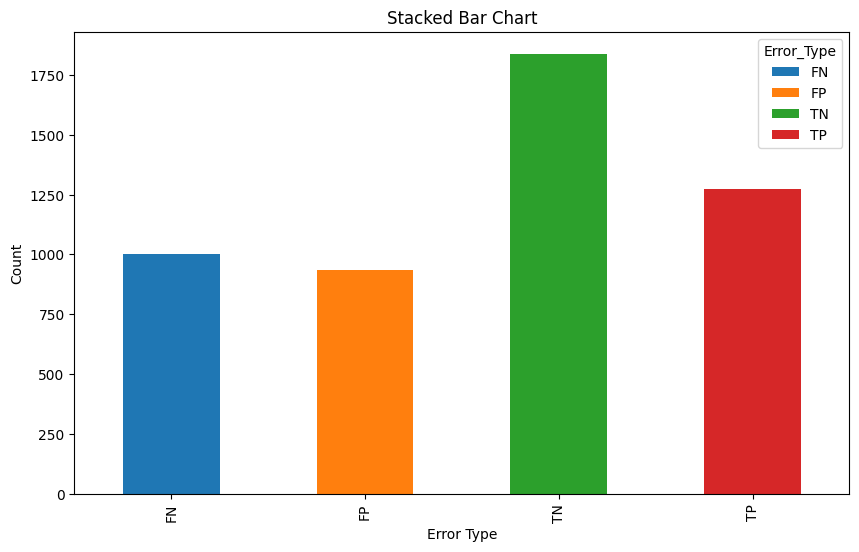

In [27]:
'''ERROR TYPE BARCHART (FP, FN, TP, TN)'''

errors_df = compas_w_error[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


In [28]:
'''ERROR LABELS PER DEMO GROUP
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = compas_w_error.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()'''

"ERROR LABELS PER DEMO GROUP \n#Group data by 'race' and 'Error_Type' and count occurrences\nrace_error_counts = compas_w_error.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)\n\n# Normalize counts along the y-axis\nrace_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)\n\n# Plot the proportional stacked bar chart\nrace_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))\n\n# Add labels and title\nplt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')\nplt.xlabel('Demographic Group')\nplt.ylabel('Proportion')\nplt.legend(title='Error Type', loc='upper right')\n\n# Show the plot\nplt.show()"

In [29]:
'''ERROR LABELS PER GENDER
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = compas_w_error.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()'''

"ERROR LABELS PER GENDER \n#Group data by 'race' and 'Error_Type' and count occurrences\nsex_error_counts = compas_w_error.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)\n\n# Normalize counts along the y-axis\nsex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)\n\n# Plot the proportional stacked bar chart\nsex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))\n\n# Add labels and title\nplt.title('Proportional Stacked Bar Chart for Error Types per Gender')\nplt.xlabel('sex')\nplt.ylabel('Proportion')\nplt.legend(title='Error Type', loc='upper right')\n\n# Show the plot\nplt.show()"

In [30]:
'''ERROR LABELS PER AGE
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = compas_w_error.groupby(['age', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()'''

"ERROR LABELS PER AGE\n# Group data by 'age' and 'Error_Type' and count occurrences\nage_error_counts = compas_w_error.groupby(['age', 'Error_Type']).size().unstack(fill_value=0)\n\n# Normalize counts along the y-axis\nage_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)\n\n# Plot the proportional stacked bar chart\nage_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))\n\n# Add labels and title\nplt.title('Proportional Stacked Bar Chart for Error Types per Age')\nplt.xlabel('Age')\nplt.ylabel('Proportion')\nplt.legend(title='Error Type', loc='upper right')\n\n# Show the plot\nplt.show()"

In [31]:
'''ERROR LABELS PER AGE JITTER BOXPLOT

ax = sns.boxplot(x='Error_Type', y='age', data=compas_w_error)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=compas_w_error, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()'''

'ERROR LABELS PER AGE JITTER BOXPLOT\n\nax = sns.boxplot(x=\'Error_Type\', y=\'age\', data=compas_w_error)\n# add stripplot\nax = sns.stripplot(x=\'Error_Type\', y=\'age\', data=compas_w_error, color="orange", jitter=0.2, size=2.5)\n\n# add title\nplt.title("Boxplot Error Type per Age with jitter", loc="left")\n\n# show the graph\nplt.show()'

Violin plot as combination of boxplot and kernel density plot.

The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.


In [32]:
'''Violin plot as combination of boxplot and kernel density plot.
The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.
plt.figure(figsize=(22, 7))

sns.violinplot(x="race", y="age", hue = "Error_Type", data=compas_w_error)
plt.show()'''


'Violin plot as combination of boxplot and kernel density plot.\nThe width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.\nplt.figure(figsize=(22, 7))\n\nsns.violinplot(x="race", y="age", hue = "Error_Type", data=compas_w_error)\nplt.show()'

In [33]:
'''plt.figure(figsize=(12, 6))

sns.kdeplot(data=compas_w_error, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)

plt.show()'''


'plt.figure(figsize=(12, 6))\n\nsns.kdeplot(data=compas_w_error, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)\n\nplt.show()'

# SHAP

In [25]:
!pip install shap
import shap

## Performing shap values on testset

SHAP Values: While Random Forests do not require scaling, SHAP values (SHapley Additive exPlanations) are used to interpret the impact of features on the model's output. Scaling features can sometimes make SHAP values more interpretable, especially when features have very different ranges.

In [34]:
#Performing SHAP explainer on the trainset to get the shap values on the testset
tree_explainer = shap.TreeExplainer(model, X_train)

#df_shap_values_ = tree_explainer(X_test, check_additivity=False) #this returns an object instead of an array

shap_values = tree_explainer.shap_values(X_test, check_additivity=False) #Molnar book: if additivity doesnt hold the code produces an error - disable it


100%|===================| 10079/10100 [04:42<00:00]       

In [35]:
'''SHAP returns a list of two arrays one for each class (0 and 1) and gives back a shape of (5050, 14, 2).
It gives an error for mismatch between feature columns in shap and X_test shape (5050,2)'''

shap_values_class1 = shap_values[:, :, 1]  # Select all samples, all features, class 1 for fraud

#plot
#shap.plots.waterfall(shap_values_class1, max_display=11)
#shap.plots.beeswarm(df_shap_values_[0])

#print(shap_values_class1)

# Add SHAP Values to dataset

In [36]:
df_shap_values = pd.DataFrame(shap_values_class1, columns=[f'Shap_{col}' for col in X_test.columns])

df_shap_values.iloc[3]

,3
Shap_age_y,-0.127752
Shap_decile_score_y,-0.001879
Shap_priors_count_y,-0.174768
Shap_sex_Female_y,-0.017723
Shap_race_African-American_y,-0.004598
Shap_race_Asian_y,0.000000
Shap_race_Caucasian_y,0.029702
Shap_race_Hispanic_y,0.007378
Shap_race_Native American_y,0.000000
Shap_race_Other_y,0.000234


In [37]:
df_shap_values_scaled = scaler.fit_transform(df_shap_values)
df_shap_values_scaled = pd.DataFrame(df_shap_values_scaled, columns=df_shap_values.columns)
df_shap_values_scaled.iloc[3]

,3
Shap_age_y,-1.134291
Shap_decile_score_y,0.123042
Shap_priors_count_y,-1.117558
Shap_sex_Female_y,-0.447878
Shap_race_African-American_y,0.130622
Shap_race_Asian_y,0.064734
Shap_race_Caucasian_y,1.252979
Shap_race_Hispanic_y,0.396952
Shap_race_Native American_y,-0.056658
Shap_race_Other_y,0.145690


In [38]:
shap_values_all = pd.merge(df_shap_values, df_shap_values_scaled, left_index=True, right_index=True)
shap_values_all.iloc[3]

,3
Shap_age_y_x,-0.127752
Shap_decile_score_y_x,-0.001879
Shap_priors_count_y_x,-0.174768
Shap_sex_Female_y_x,-0.017723
Shap_race_African-American_y_x,-0.004598
Shap_race_Asian_y_x,0.000000
Shap_race_Caucasian_y_x,0.029702
Shap_race_Hispanic_y_x,0.007378
Shap_race_Native American_y_x,0.000000
Shap_race_Other_y_x,0.000234


In [39]:
# rename columns for shap
def rename_columns_shap(col):
    if '_y_x' in col:
        return col.replace('_y_x', '')
    elif '_y_y' in col:
        return col.replace('_y_y', '') + '_scaled'
    else:
        return col

# Apply the function to rename columns
all_shap_values = shap_values_all.rename(columns=rename_columns_shap)

# Display the updated column names
print(all_shap_values.columns)


Index(['Shap_age', 'Shap_decile_score', 'Shap_priors_count', 'Shap_sex_Female',
       'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
       'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other',
       'Shap_age_scaled', 'Shap_decile_score_scaled',
       'Shap_priors_count_scaled', 'Shap_sex_Female_scaled',
       'Shap_race_African-American_scaled', 'Shap_race_Asian_scaled',
       'Shap_race_Caucasian_scaled', 'Shap_race_Hispanic_scaled',
       'Shap_race_Native American_scaled', 'Shap_race_Other_scaled'],
      dtype='object')


# Make Master Compas dataset with Error, SHAP values & Basic features

In [40]:
#add back removed columns to create final dataset
Compas_w_error_shap = pd.merge(compas_w_error, all_shap_values, left_index=True, right_index=True)
Compas_w_error_shap.info()
Compas_w_error_shap.iloc[3]

<class 'pandas.core.frame.DataFrame'>
Index: 3529 entries, 1 to 5049
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   age_x                              3529 non-null   float64 
 1   decile_score_x                     3529 non-null   float64 
 2   priors_count_x                     3529 non-null   float64 
 3   sex_Female_x                       3529 non-null   float64 
 4   race_African-American_x            3529 non-null   float64 
 5   race_Asian_x                       3529 non-null   float64 
 6   race_Caucasian_x                   3529 non-null   float64 
 7   race_Hispanic_x                    3529 non-null   float64 
 8   race_Native American_x             3529 non-null   float64 
 9   race_Other_x                       3529 non-null   float64 
 10  age_y                              3529 non-null   float64 
 11  decile_score_y                     3529 non-null

,4
age_x,43.0
decile_score_x,1.0
priors_count_x,2.0
sex_Female_x,0.0
race_African-American_x,0.0
race_Asian_x,0.0
race_Caucasian_x,0.0
race_Hispanic_x,0.0
race_Native American_x,0.0
race_Other_x,1.0


In [41]:
#add scaled errors as well..
ERRORS_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
df_errors = Compas_w_error_shap[ERRORS_COL] # Extract the actual data from these columns

df_errors.iloc[3]

,4
errors,0.0
TP,0.0
TN,1.0
FN,0.0
FP,0.0


In [42]:
df_errors_scaled = scaler.fit_transform(df_errors)
df_errors_scaled = pd.DataFrame(df_errors_scaled, columns=ERRORS_COL) # Keep the original column names
df_errors_scaled.iloc[3]

,3
errors,-0.783814
TP,-0.579423
TN,1.310231
FN,-0.497431
FP,-0.472017


In [43]:
C_w_error_shap = pd.merge(Compas_w_error_shap, df_errors_scaled, left_index=True, right_index=True)
C_w_error_shap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2474 entries, 1 to 3528
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   age_x                              2474 non-null   float64 
 1   decile_score_x                     2474 non-null   float64 
 2   priors_count_x                     2474 non-null   float64 
 3   sex_Female_x                       2474 non-null   float64 
 4   race_African-American_x            2474 non-null   float64 
 5   race_Asian_x                       2474 non-null   float64 
 6   race_Caucasian_x                   2474 non-null   float64 
 7   race_Hispanic_x                    2474 non-null   float64 
 8   race_Native American_x             2474 non-null   float64 
 9   race_Other_x                       2474 non-null   float64 
 10  age_y                              2474 non-null   float64 
 11  decile_score_y                     2474 non-null

In [44]:
# Remove `_x` from columns
def rename_columns_error(col):
    if '_x' in col:
        return col.replace('_x', '')
    elif '_y' in col:
        return col.replace('_y', '') + '_scaled'
    else:
        return col

# Apply the function to rename columns
C_w_error_shap = C_w_error_shap.rename(columns=rename_columns_error)

# Display the updated column names
print(C_w_error_shap.columns)

Index(['age', 'decile_score', 'priors_count', 'sex_Female',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'age_scaled',
       'decile_score_scaled', 'priors_count_scaled', 'sex_Female_scaled',
       'race_African-American_scaled', 'race_Asian_scaled',
       'race_Caucasian_scaled', 'race_Hispanic_scaled',
       'race_Native American_scaled', 'race_Other_scaled', 'predicted_class',
       'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type',
       'Shap_age', 'Shap_decile_score', 'Shap_priors_count', 'Shap_sex_Female',
       'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
       'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other',
       'Shap_age_scaled', 'Shap_decile_score_scaled',
       'Shap_priors_count_scaled', 'Shap_sex_Female_scaled',
       'Shap_race_African-American_scaled', 'Shap_race_Asian_scaled',
       'Shap_race_Caucasian_scaled', 'Shap

In [45]:
C_w_error_shap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2474 entries, 1 to 3528
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   age                                2474 non-null   float64 
 1   decile_score                       2474 non-null   float64 
 2   priors_count                       2474 non-null   float64 
 3   sex_Female                         2474 non-null   float64 
 4   race_African-American              2474 non-null   float64 
 5   race_Asian                         2474 non-null   float64 
 6   race_Caucasian                     2474 non-null   float64 
 7   race_Hispanic                      2474 non-null   float64 
 8   race_Native American               2474 non-null   float64 
 9   race_Other                         2474 non-null   float64 
 10  age_scaled                         2474 non-null   float64 
 11  decile_score_scaled                2474 non-null

In [48]:
# Drop sex, race, predicted_class, and true_class columns
Compas_error_shap = C_w_error_shap.drop(['predicted_class', 'true_class'], axis=1)

# Verify changes
#Compas_error_shap.info()

# FINAL DATASET to CSV

In [57]:
Compas_error_shap.to_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks/Compas_error_shap.csv', index=False)


In [50]:
# MASTER DATASET
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled', 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']


# PCA & TSNE

In [51]:
#Each point represents an observation in entire_dataset.
#Points closer together have similar patterns across features. Clusters may indicate subgroups. Outliers deviate from the general pattern

def pca_plot(data, title, alpha, pca_columns):
  if not isinstance(pca_columns, list):
    raise ValueError ("pca columns should be a list of column names")

    for col in pca_columns:
      if col not in data.columns:
        raise ValueError(f"{col} not in dataframe")

    # Extract features for PCA and drop Meta_colums
    pca_features = data[pca_columns]
    other_features = data.drop[pca_columns]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns, other_columns = None):
    # Ensure tsne_columns is a list and contains valid columns
    if not isinstance(tsne_columns, list):
        raise ValueError("tsne_columns should be a list of column names.")

    # Check if the selected columns are in the dataframe
    for col in tsne_columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is not in the dataframe.")

    # Initialize other_columns to empty list if not provided
    if other_columns is None:
        other_columns = []

    # Ensure other_columns is a list and contains valid columns
    if not isinstance(other_columns, list):
        raise ValueError("other_columns should be a list of column names.")

    # Exclude tsne_columns from other_columns
    exclude_columns = tsne_columns
    other_columns = [col for col in data.columns if col not in exclude_columns]

    # Extract features for t-SNE and drop Meta_columns
    tsne_features = data[tsne_columns]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

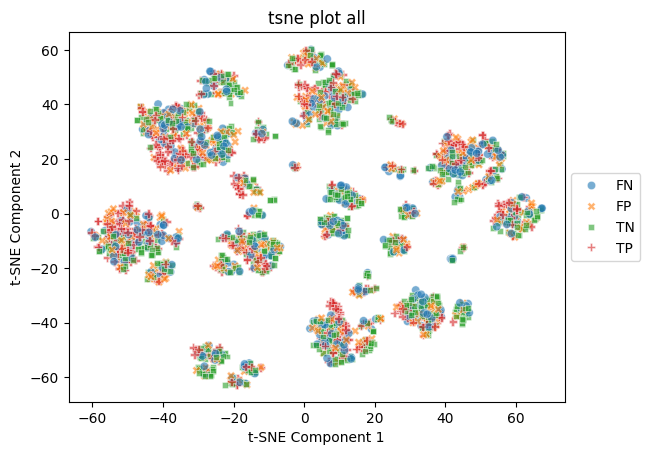

In [52]:
'''PLOT for shap, error and features'''
#pca_plot(Compas_w_error_shap, 'pca plot all', 0.6, pca_columns=BASIC_COL_unscaled + ERROR_COL + SHAP_COL_Basic_scaled, scale_data=True)
#plt.show()

tsne_plot(Compas_error_shap, 'tsne plot all', 30, 200, 1000, 0.6, tsne_columns=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns= None)
plt.show()


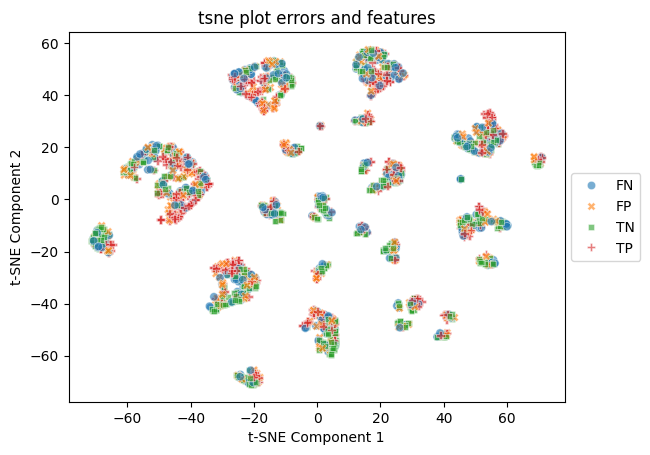

In [53]:
'''Plot with error and features without SHAP'''
tsne_plot(Compas_error_shap, 'tsne plot errors and features', 30, 200, 1000, 0.6,
          tsne_columns=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled, other_columns= SHAP_BASIC_scaled + SHAP_DUMMY_scaled)
plt.show()

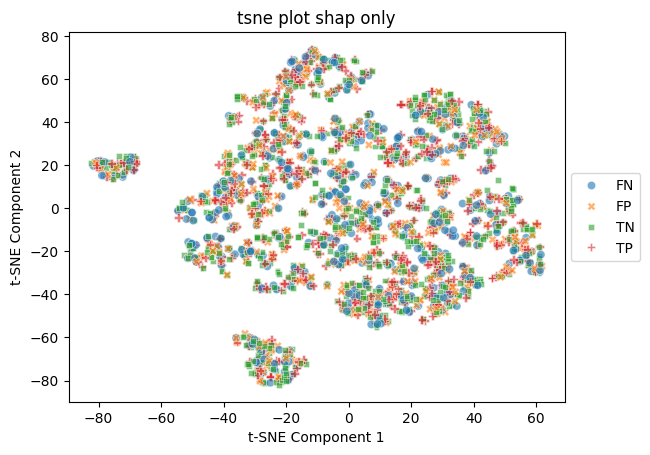

In [54]:
'''TSNE with only SHAP'''
tsne_plot(Compas_error_shap, 'tsne plot shap only', 30, 200, 1000, 0.6,
          tsne_columns= SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns= BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled)
plt.show()

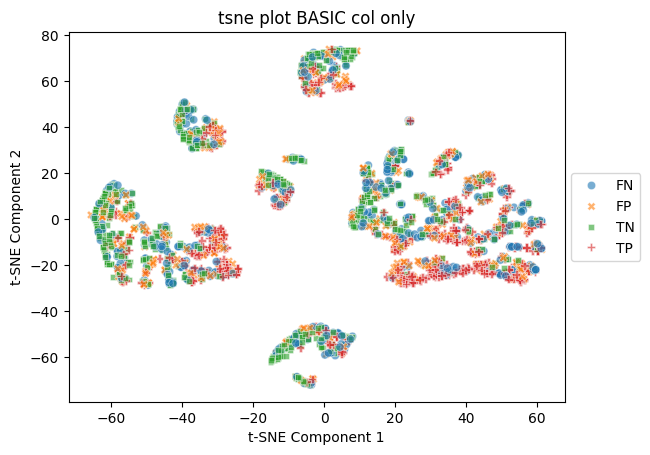

In [55]:
'''TSNE with only BASIC COL'''
tsne_plot(Compas_error_shap, 'tsne plot BASIC col only', 30, 200, 1000, 0.6,
          tsne_columns=BASIC_COL_scaled + DUMMY_COL_scaled, other_columns= ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled)
plt.show()

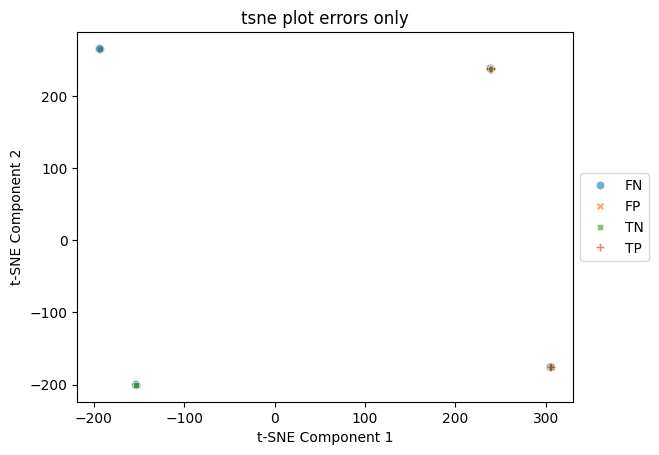

In [56]:
'''TSNE with only ERROR'''
tsne_plot(Compas_error_shap, 'tsne plot errors only', 30, 200, 1000, 0.6,
          tsne_columns=ERROR_COL_scaled, other_columns= BASIC_COL_scaled + DUMMY_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled)
plt.show()